# Dictionary Initialization

In [1]:
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the RW predictor
rwValues = []
rwMeanRegretValues = []
rwMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

# Import Data

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272
original returns dataframe dimension: (3272, 3)


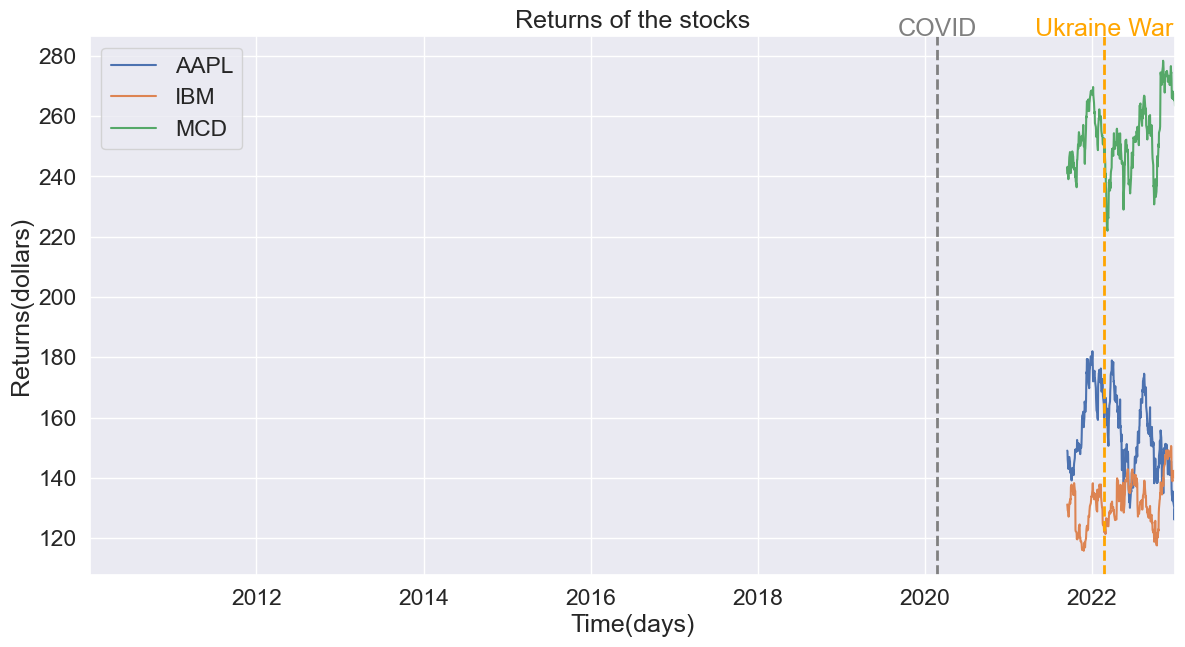

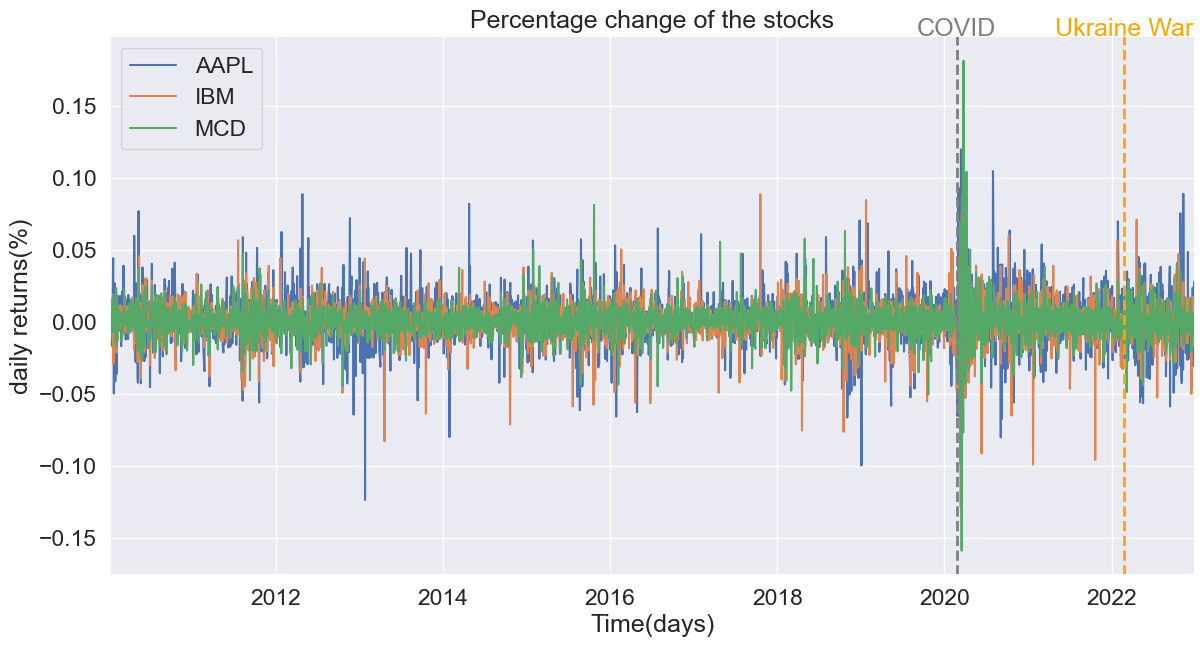

2010-01-04 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-05 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-06 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-07 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-08 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
dimension of the prescient dictionary: 3272
2010-01-04 00:00:00
          7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0

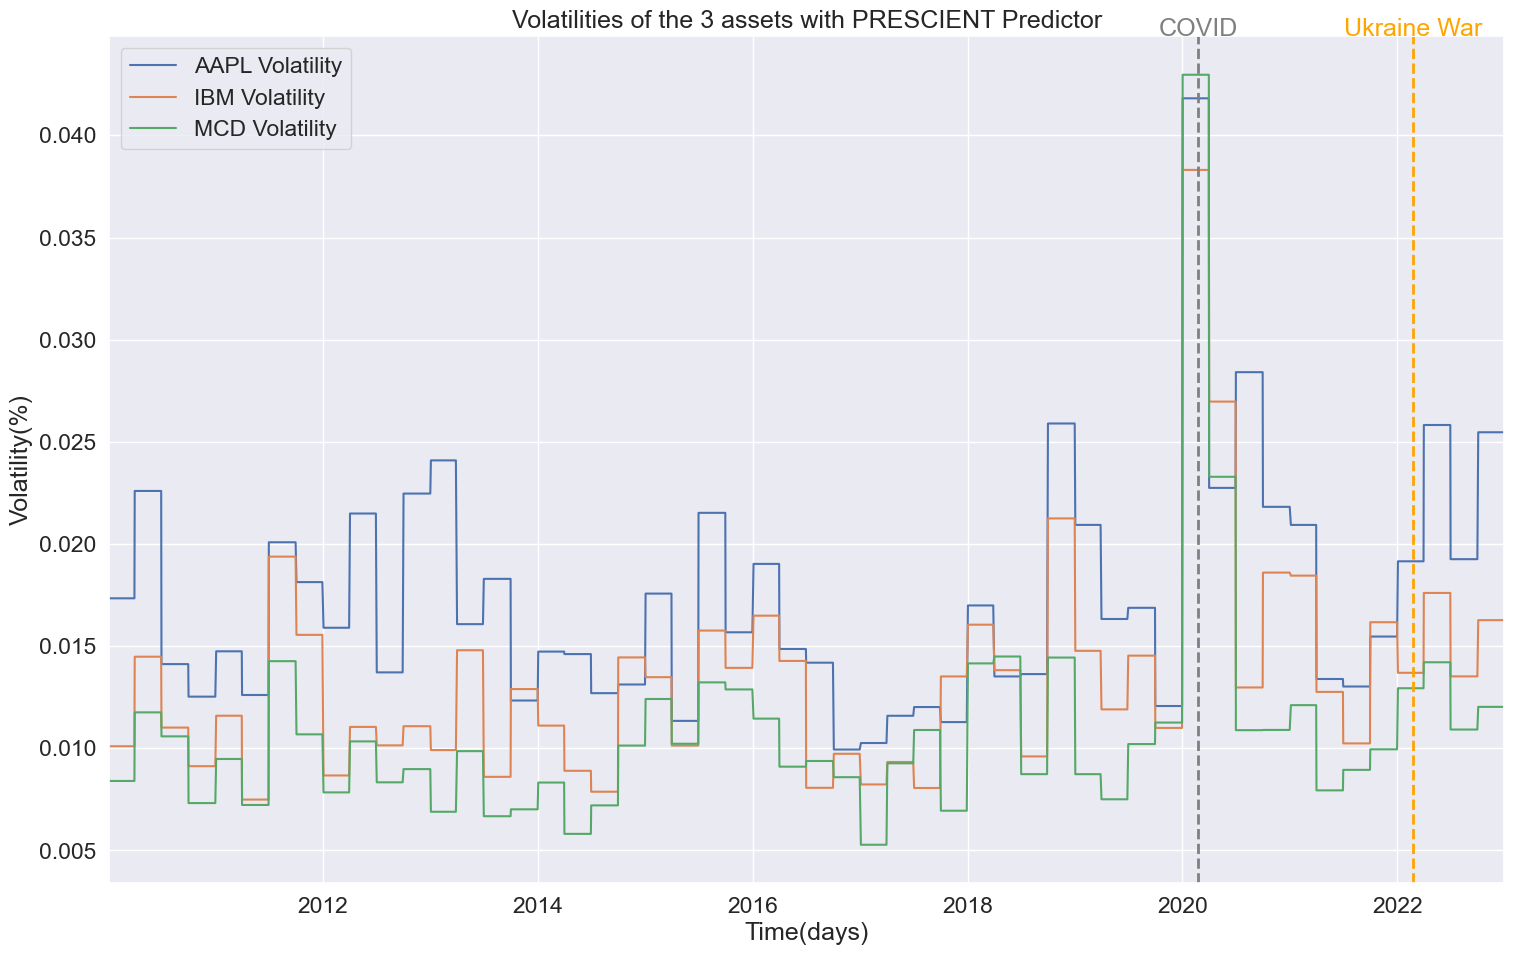

In [2]:
from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)
from performanceMeasurement import * # this file contains the implementation of the performance measurement functions(like rmse, loglikelihood, regret, etc)

# Covariance Predictors

FOR THE RW PREDICTOR THERE IS NO TRAINING PHASE, THE PREDICTOR HAS M(window memory) AS UNIQUE PARAMETER AND IT IS AN HYPERPARAMETER. 
The best value for M has been found with the grid search method applied in the validation phase.

# Validation Phase for RW predictor

In [3]:
# Loop through rw_memory values

def rwValidationPhase(rw_memory, startingDate, endingDate, rw_size_increment, prescientAlreadyPrinted):
    '''
    this function is used to perform the validation phase of the RW predictor; it's used to find the best memory size of the window for the rw predictor.
    Grid search is used and the performance of the M hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while rw_memory < 700:

        rwDict = rolling_window(validationDataWithPercentageChange, rw_memory) 

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
            
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        names = ["RW", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [rwDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})
            

        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            returns_temp = validationDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

        #
        # REGRETS
        #

        for name in daily_log_likelihoods:
            daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]


        # plot the log-likelihood values of the prescient predictor
        if prescientAlreadyPrinted == False:    
            plt.figure(figsize=(14, 7))
            plt.plot(daily_log_likelihoods['PRESCIENT'].index, daily_log_likelihoods['PRESCIENT'].values, label='Prescient Daily Log-Likelihood', marker='x', linestyle='-', color='green')
            plt.title(f'Daily Log-Likelihood of the Prescient Predictor')
            plt.xlabel('Date(days)')
            plt.ylabel('Value')
            plt.legend()
            plt.show()
            prescientAlreadyPrinted = True

            
        for name in daily_regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                rwMeanRegretValues.append(regretMetrics[0])

        # copy the log-likelihoods dictionary
        daily_log_likelihoods_copy = daily_log_likelihoods.copy()
        prescientMeanlogLikelihoodValues = []

        # do the same thing for log-likelihoods dictionary
        for name in daily_log_likelihoods_copy:
            quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

            if name != "PRESCIENT":
                # save the log-likelihood mean values to plot a chart
                rwMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
            
            if name == "PRESCIENT":
            # i'm writing the prescient predictor only once, because it's the same for every rw_memory value

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
        
        # save the rw value to plot a chart
        rwValues.append(rw_memory)

        # Increment beta
        rw_memory += rw_size_increment

    # return the fundamental values to plot the charts
    return rwValues, rwMeanRegretValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues

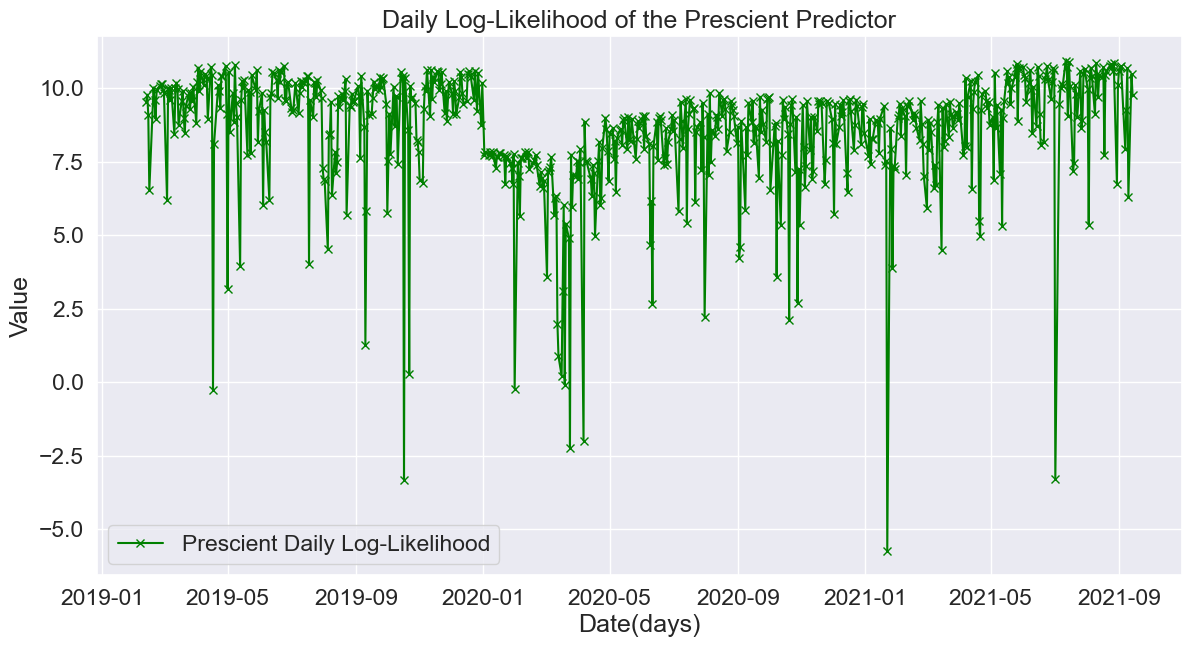

RWsizeMemory: 30.0000
 Log-likelihood: 8.3000
RWsizeMemory: 70.0000
 Log-likelihood: 8.3000


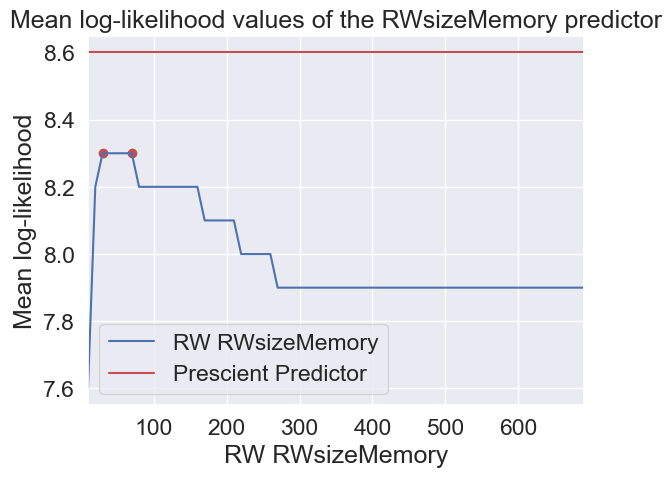

RWsizeMemory: 30.0000
 Regret: 0.3000
RWsizeMemory: 50.0000
 Regret: 0.3000


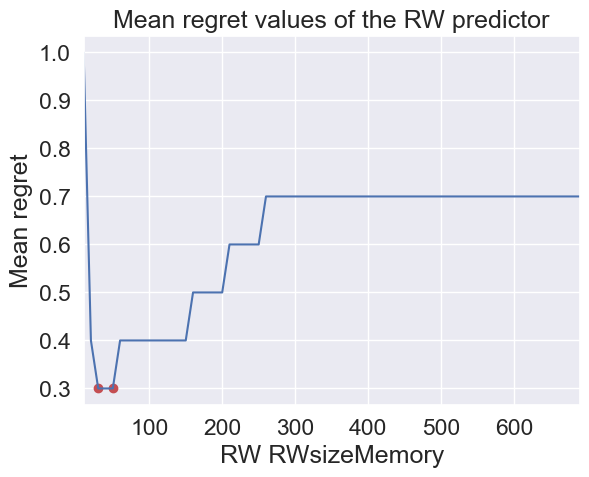

max_pointsX: [30, 70]
max_pointsY: [8.3, 8.3]
min_pointsX: [30, 50]
min_pointsY: [0.3, 0.3]


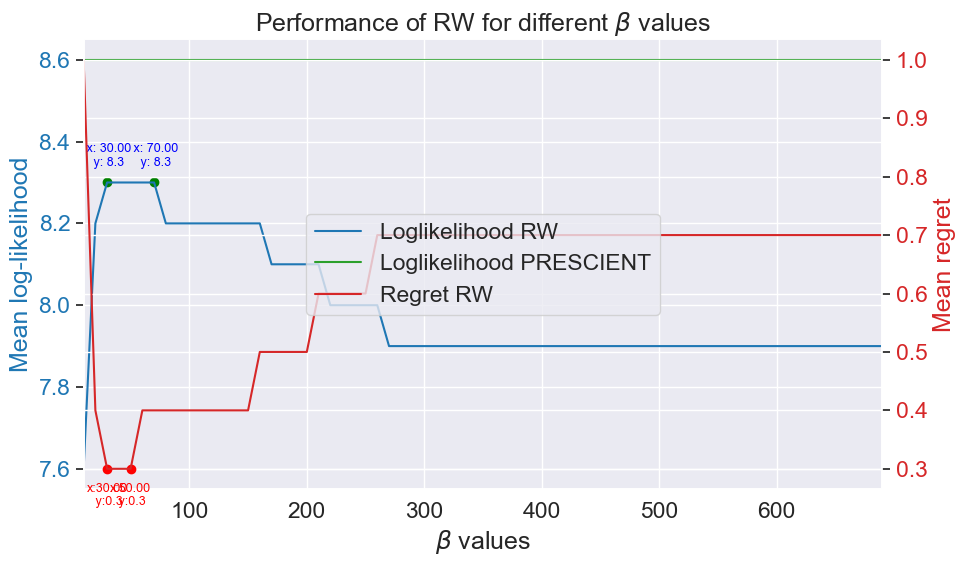

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [4]:
# to go faster i skip the validation part(the correct memoru value parameter has been already found)

# grid search run for the RW predictor
rwValues, rwMeanRegretValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = rwValidationPhase(10, startingValidationDate, endingValidationDate, 10, prescientAlreadyPrinted)

# plot the performance of the RW predictor in terms of log-likelihood
plotLogLikelihoodPerformancePredictor(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, "RW", "RWsizeMemory")

# plot the performance of the RW predictor in terms of regret
plotRegretPerformancePredictor(rwValues, rwMeanRegretValues, "RW", "RWsizeMemory")

# plot the performance of the RW predictor in terms of log-likelihood and regret
plotPerformancePredictor(rwValues, rwMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, rwMeanRegretValues, 'RW', "RWsizeMemory")


In [5]:
'''
# example with wrong memory value parameter

# select the best memory size for the RW predictor(the one found in the validation phase)

rw_memory = 500

rwDict = rolling_window(validationDataWithPercentageChange, rw_memory)
    
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingValidationDate)
real_volatility_endDate = pd.to_datetime(endingValidationDate)

rw_volatilities, df_rw_volatility_aapl, df_rw_volatility_ibm, df_rw_volatility_mcd, rw_volatility_dict_aapl, rw_volatility_dict_ibm, rw_volatility_dict_mcd = plot_volatility(rwDict, real_volatility_startDate, real_volatility_endDate, 'RW')
'''

"\n# example with wrong memory value parameter\n\n# select the best memory size for the RW predictor(the one found in the validation phase)\n\nrw_memory = 500\n\nrwDict = rolling_window(validationDataWithPercentageChange, rw_memory)\n    \n# now filter the rw volatilities between the start and end date\nreal_volatility_startDate = pd.to_datetime(startingValidationDate)\nreal_volatility_endDate = pd.to_datetime(endingValidationDate)\n\nrw_volatilities, df_rw_volatility_aapl, df_rw_volatility_ibm, df_rw_volatility_mcd, rw_volatility_dict_aapl, rw_volatility_dict_ibm, rw_volatility_dict_mcd = plot_volatility(rwDict, real_volatility_startDate, real_volatility_endDate, 'RW')\n"

In [6]:
'''
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE RW PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_rw(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')
'''

"\n# HERE THERE IS THE VOLATILITY ANALYSIS OF THE RW PREDICTOR COMPARED TO THE REAL VOLATILITY\nstartDateFilter = validationDataWithPrices.index[0]\nendDateFilter = validationDataWithPrices.index[-1]\n\nplot_prices_volatilities_for_rw(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')\n"

# Test Phase for RW predictor

In this test phase i will use the best value for rw_memory found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

to be more fair in the measure of the model performance i will remove the first 19 days from every predictor dict minus the rolling window predictor dict.

rw_memory: 50
the timestamp of the first element of the rolling window dictionary: 2021-10-12 00:00:00
the first element of the rolling window dictionary:           7         20990     21177
7      0.000148  0.000045  0.000067
20990  0.000045  0.000119  0.000036
21177  0.000067  0.000036  0.000066


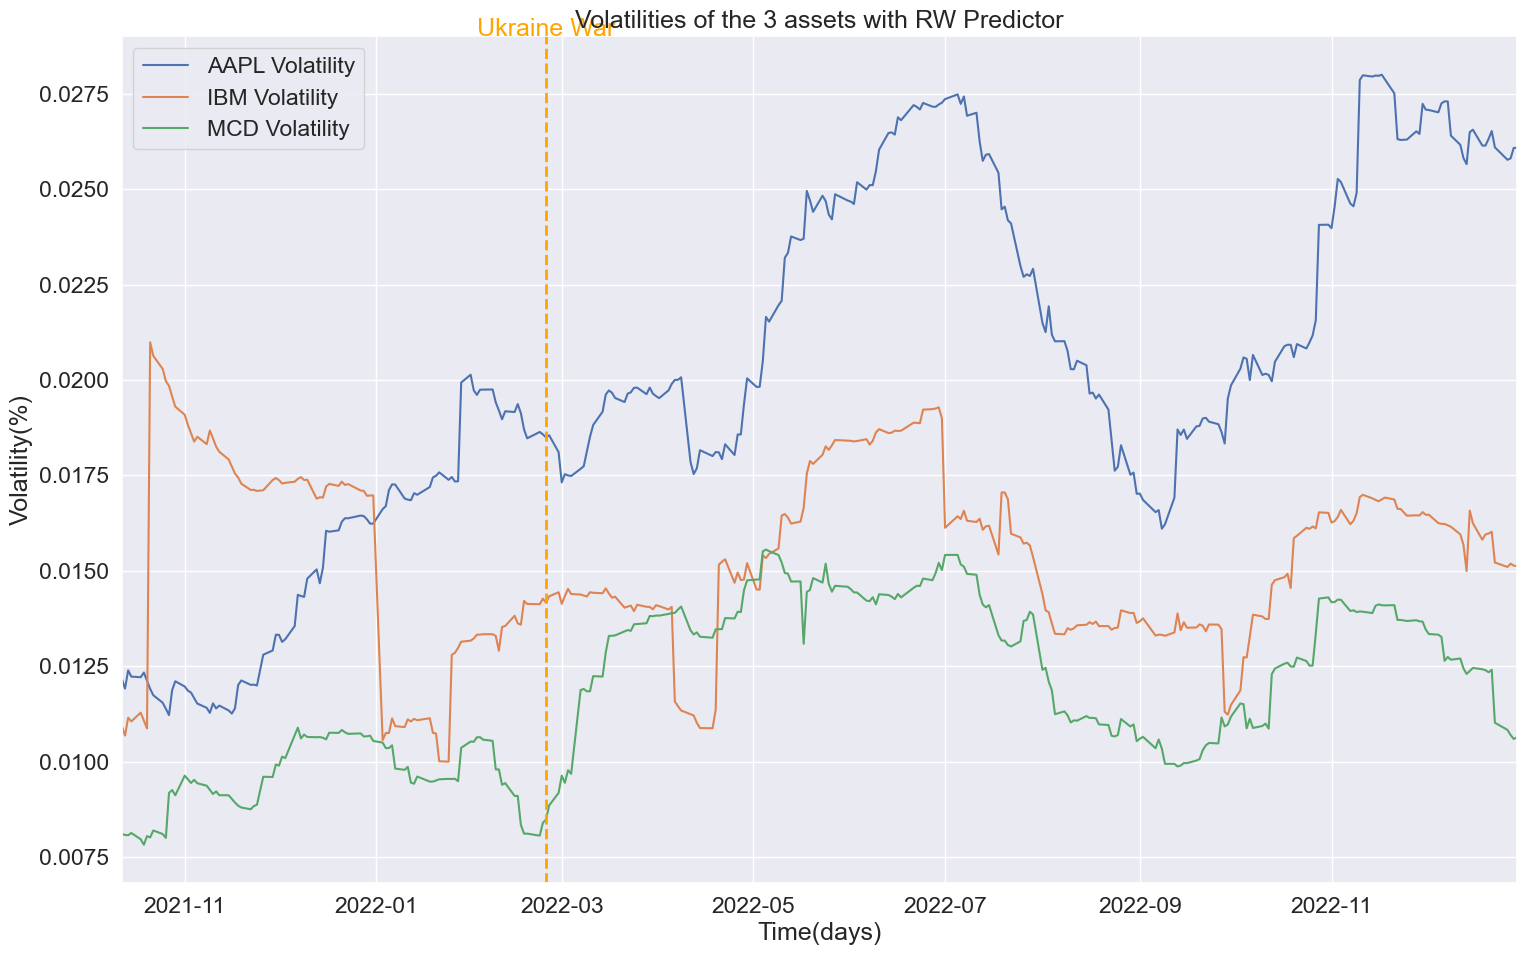

In [7]:
# select the best memory size for the RW predictor(the one found in the validation phase)

# here i take the correct configuration( basing on the number of stock in my portfolio)
rw_memory = predictorsConfiguration["RW_memorySize"]
print("rw_memory: " + str(rw_memory))

rwDict = rolling_window(testDataWithPercentageChange, rw_memory)

print("the timestamp of the first element of the rolling window dictionary: " + str(list(rwDict.keys())[0]))
print("the first element of the rolling window dictionary: " + str(rwDict[list(rwDict.keys())[0]]))
    
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# assets names are AAPL, IBM, MCD, KO, PEP, JNJ, ORCL, PFE, WMT
df_rw_volatility_aapl, df_rw_volatility_ibm, df_rw_volatility_mcd, df_rw_volatility_ko, df_rw_volatility_pep, df_rw_volatility_jnj, df_rw_volatility_orcl, df_rw_volatility_pfe, df_rw_volatility_wmt, rw_volatility_dict_aapl, rw_volatility_dict_ibm, rw_volatility_dict_mcd, rw_volatility_dict_ko, rw_volatility_dict_pep, rw_volatility_dict_jnj, rw_volatility_dict_orcl, rw_volatility_dict_pfe, rw_volatility_dict_wmt = plot_volatility(rwDict, real_volatility_startDate, real_volatility_endDate, 'RW')

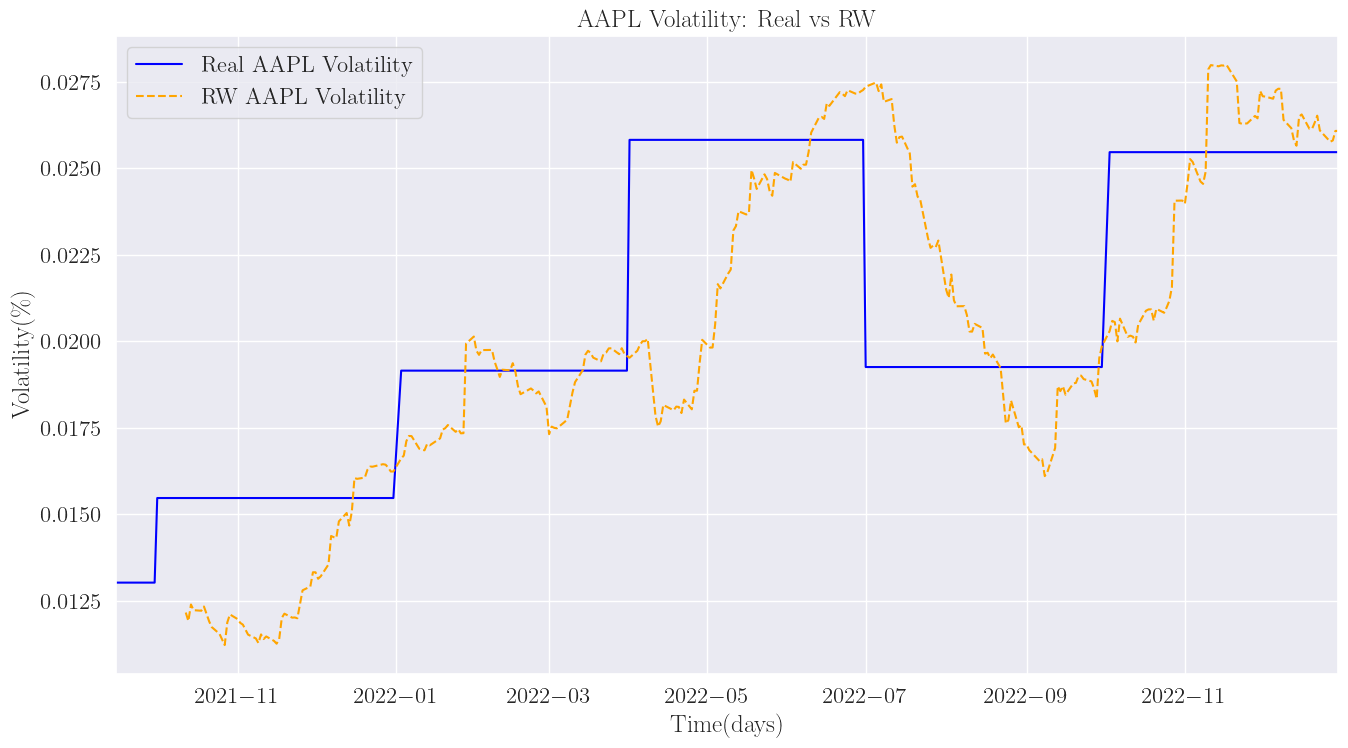

In [8]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL', "RW")

2021-09-15 00:00:00


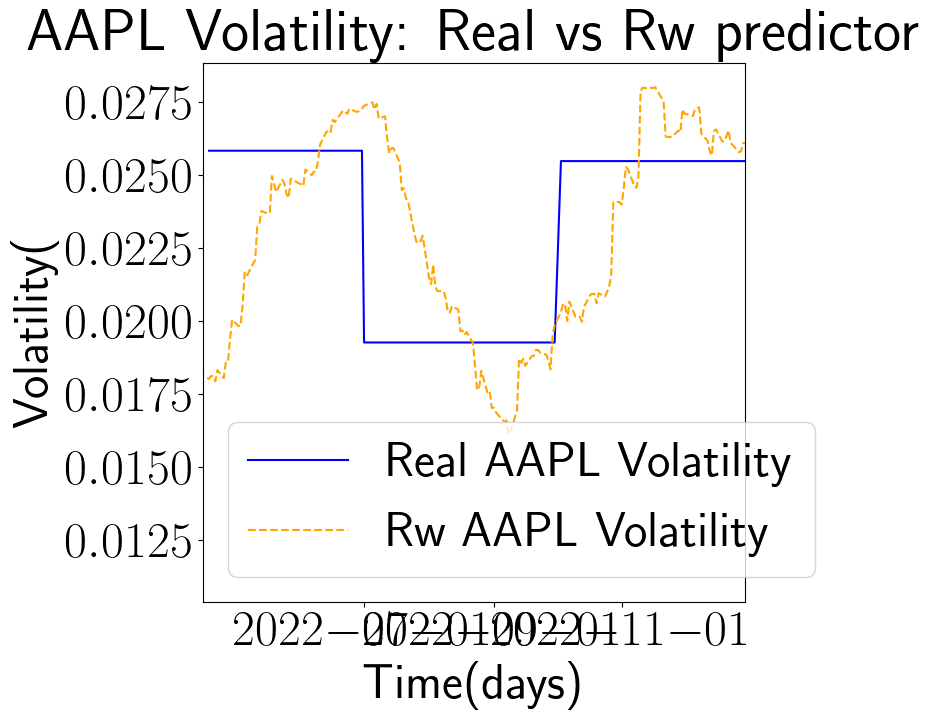

In [16]:
####################### code for test ####################################
print(startDateFilter)

def plot_prices_volatilities_for_ewAndRWTest(real_volatility, real_volatility_startDate, real_volatility_endDate, hybrid_volatility, asset_name):
    # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = ['Times New Roman'] + mpl.rcParams['font.serif']
    mpl.rcParams['font.size'] = 36
    mpl.rcParams['figure.figsize'] = [7, 7]

    fig, ax1 = plt.subplots(figsize=(7, 7))


    # Plot real and rolling window volatilities
    ax1.plot(real_volatility_filtered, label='Real AAPL Volatility', color='blue')
    ax1.plot(hybrid_volatility, label='Rw AAPL Volatility', color='orange', linestyle='--')
    ax1.set_title('AAPL Volatility: Real vs Rw predictor')
    ax1.set_xlabel('Time(days)')
    ax1.set_ylabel('Volatility(%)')
    plt.legend(loc='lower left')

    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    
    # put just 3 dates on the x-axis, exactly this ones: 2022-07, 2022-09, 2022-11
    ax1.set_xticks([pd.to_datetime('2022-07'), pd.to_datetime('2022-09'), pd.to_datetime('2022-11')])
    
    # Disable default style
    plt.style.use('default')

    # Show the plot
    plt.show()
    
    # save the eps file
    fig.savefig(partialPath + f'plots_rw_volatilities.svg', format='svg', dpi=1000)


# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_ewAndRWTest(df_volatility_aapl['AAPL Volatility'], "2022-04-15", endDateFilter, df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')
##########################################################################

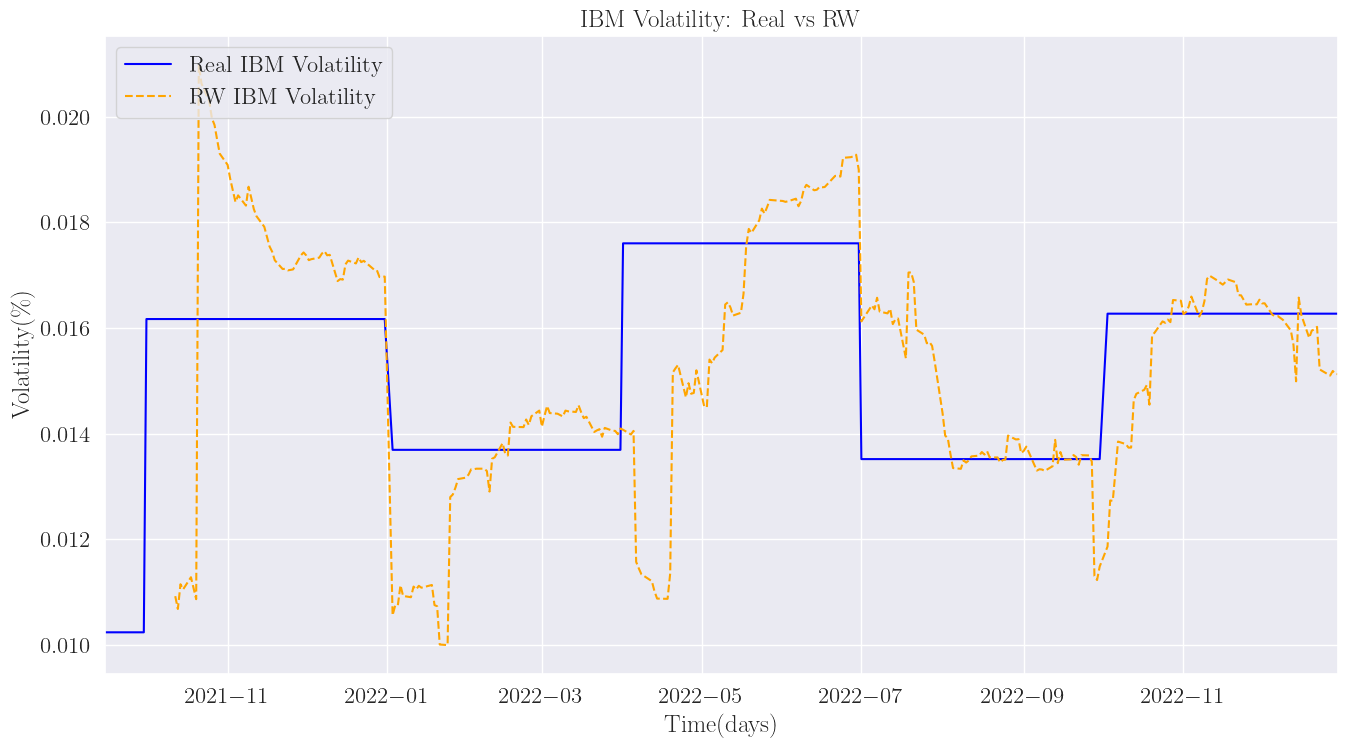

In [10]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_rw_volatility_ibm['IBM Volatility'], 'IBM', "RW")

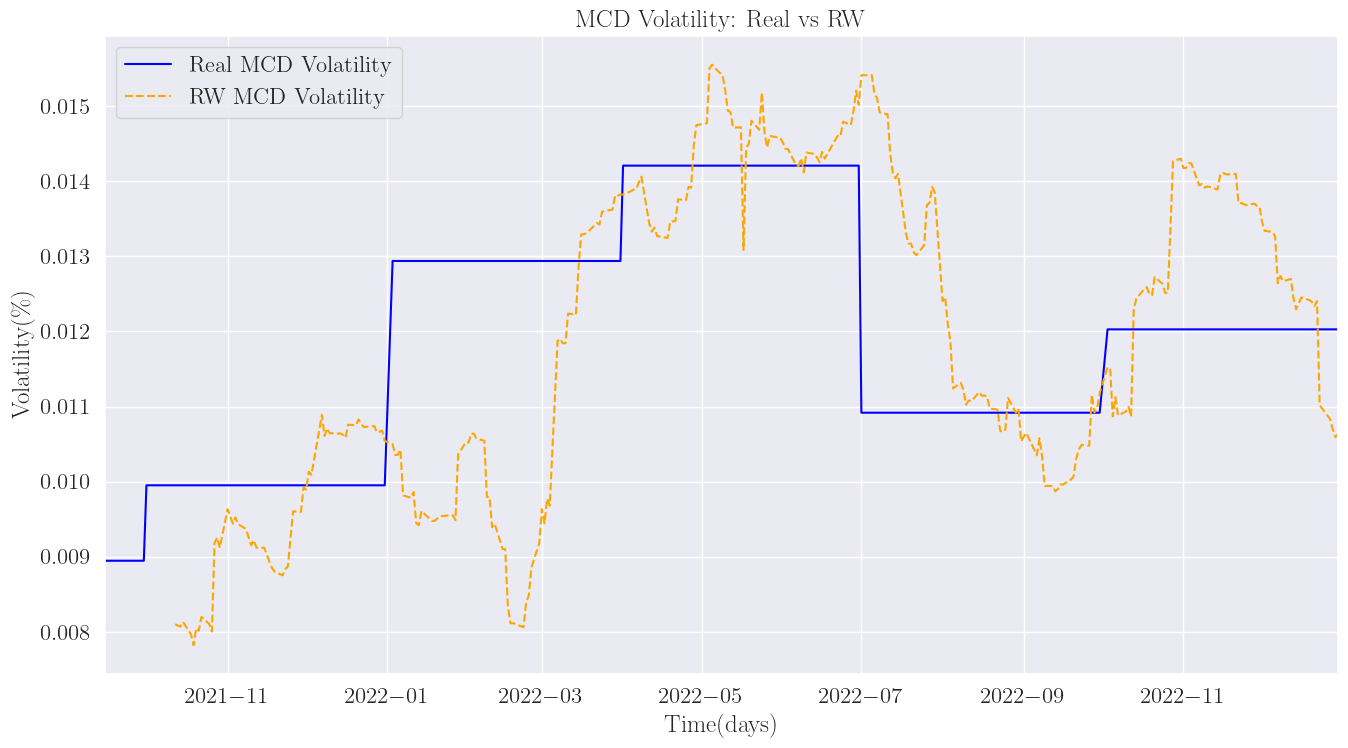

In [11]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_rw_volatility_mcd['MCD Volatility'], 'MCD', "RW")

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


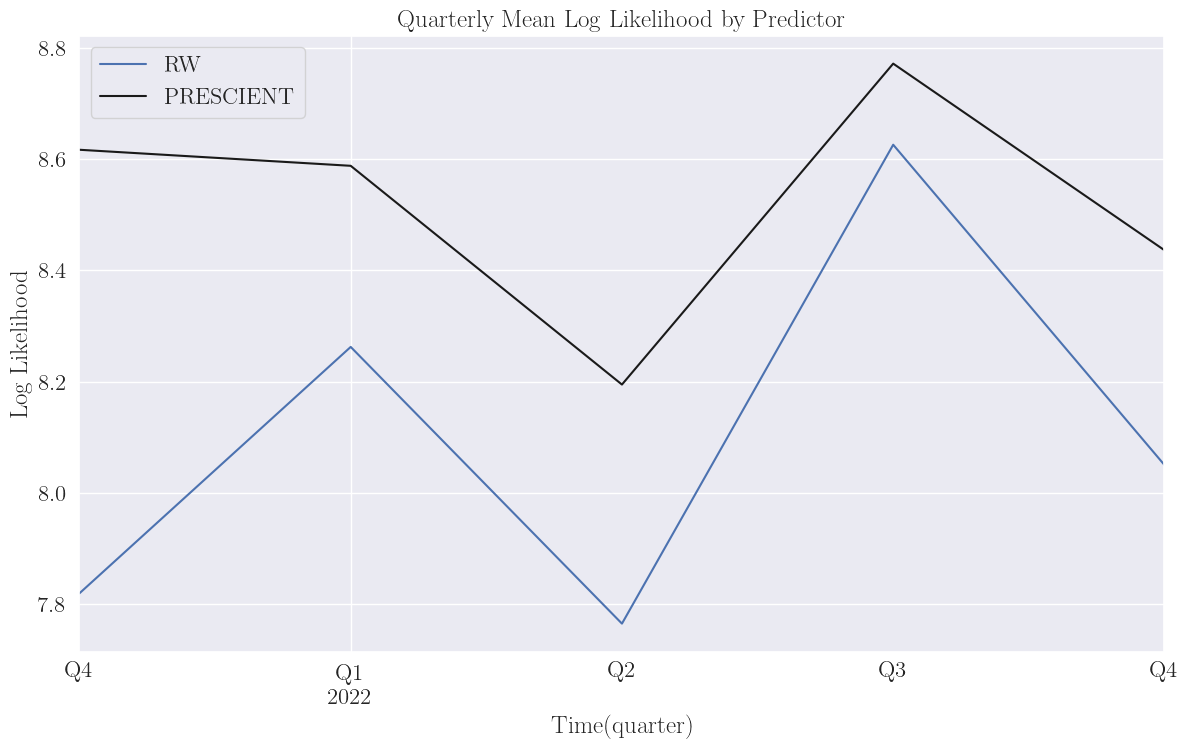

logLikelihood length:  5
logLikelihood shape:  (5,)


meanLoglikelihoodRW: 8.100
stdLoglikelihoodRW: 0.300
maxLoglikelihoodRW: 8.600
logLikelihood length:  5
logLikelihood shape:  (5,)


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800


meanRegret: 0.400
stdRegret: 0.200
maxRegret: 0.800
lenght of prescientDict:  308
lenght of rwDict:  308
lenght of predictorDict:  308

RW RMSE
mean: 0.0135287164
std: 0.0020628591
max: 0.0163685192
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.01074709212566627, Timestamp('2022-03-31 00:00:00'): 0.011859823873973241, Timestamp('2022-06-30 00:00:00'): 0.01636851922918637, Timestamp('2022-10-02 00:00:00'): 0.015168525875862524, Timestamp('2022-12-29 00:00:00'): 0.013499620975223255}


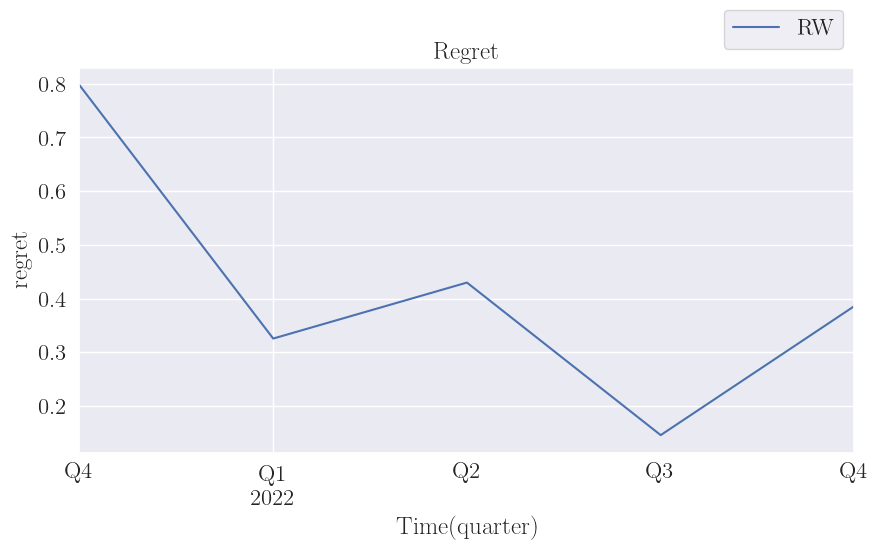

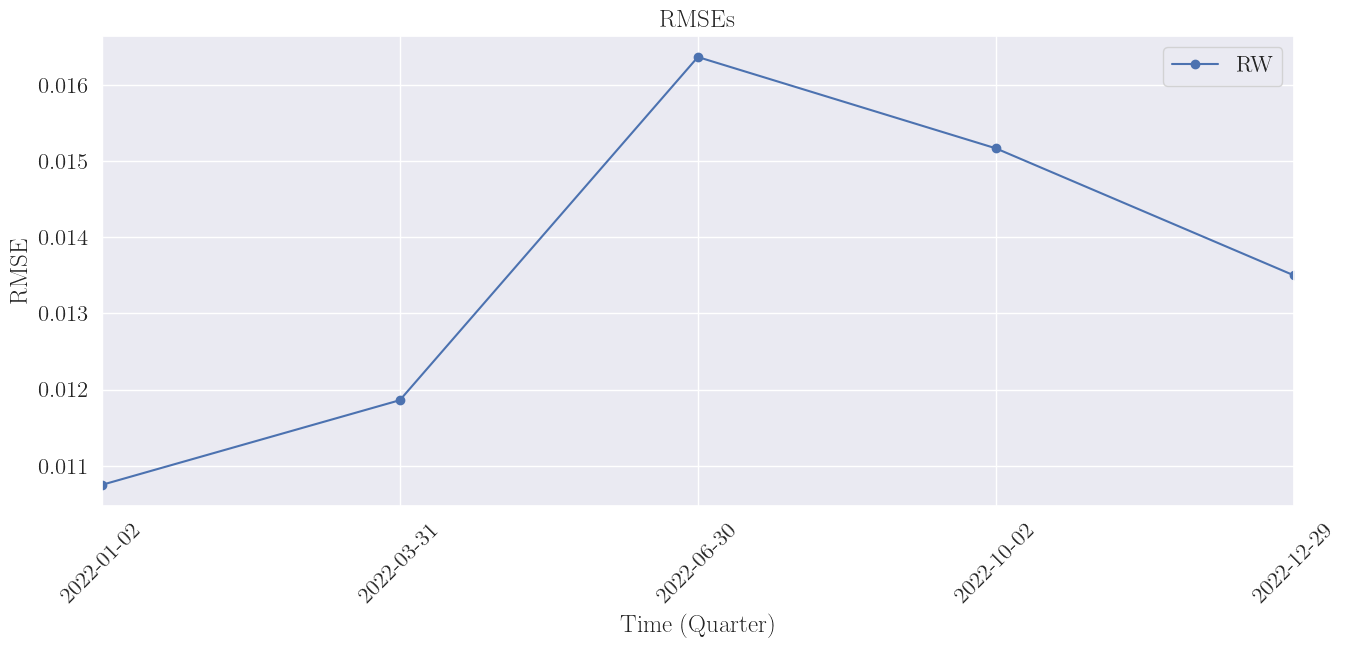

lenght of volatility_dict_aapl:  308
lenght of volatility_dict_aaapl_rw:  308
lenght of RMSEs_aapl:  5
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.0027600197636319184, Timestamp('2022-03-31 00:00:00'): 0.0012720801540746327, Timestamp('2022-06-30 00:00:00'): 0.004470106968434213, Timestamp('2022-10-02 00:00:00'): 0.0036919397632886914, Timestamp('2022-12-29 00:00:00'): 0.0029246678394582826}


RMSEs for AAPL
mean: 0.0030237629
std: 0.0010664093
max: 0.0044701070


RMSEs for IBM
mean: 0.0019626498
std: 0.0006390627
max: 0.0029480616


RMSEs for MCD
mean: 0.0015576934
std: 0.0007859137
max: 0.0028852059
Stored 'rwDictFiltered' (dict)


In [12]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset
start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["RW", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [rwDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDict = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDict = {k: prescientDict[k] for k in list(prescientDict)[19:]}
predictors[1] = prescientDict

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

# if we are here, it means that the two predictors have the same length and the same timestamps so i can measure the performance of the two predictors

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        rw: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

daily_log_likelihoods = predictorLogLikelihood(testDataWithPercentageChange, predictors, names)

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        rw: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
predictorRegret(daily_log_likelihoods, names)

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of rwDict: ", len(rwDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDict.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_filtered = {k: v for k, v in volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_filtered = {k: v for k, v in volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_filtered = {k: v for k, v in volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_filtered = {k: v for k, v in volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_filtered = {k: v for k, v in volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_filtered = {k: v for k, v in volatility_dict_wmt.items() if k >= startDAte}

volatility_dict_aapl_rw_filtered = {k: v for k, v in rw_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_rw_filtered = {k: v for k, v in rw_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_rw_filtered = {k: v for k, v in rw_volatility_dict_mcd.items() if k >= startDAte}
volatility_dict_ko_rw_filtered = {k: v for k, v in rw_volatility_dict_ko.items() if k >= startDAte}
volatility_dict_pep_rw_filtered = {k: v for k, v in rw_volatility_dict_pep.items() if k >= startDAte}
volatility_dict_jnj_rw_filtered = {k: v for k, v in rw_volatility_dict_jnj.items() if k >= startDAte}
volatility_dict_orcl_rw_filtered = {k: v for k, v in rw_volatility_dict_orcl.items() if k >= startDAte}
volatility_dict_pfe_rw_filtered = {k: v for k, v in rw_volatility_dict_pfe.items() if k >= startDAte}
volatility_dict_wmt_rw_filtered = {k: v for k, v in rw_volatility_dict_wmt.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_rw: ", len(volatility_dict_aapl_rw_filtered))

RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_rw_filtered, volatility_dict_ibm_rw_filtered, volatility_dict_mcd_rw_filtered, start_date)

# store the covariance matrixes dict of the filtered dataset
rwDictFiltered = predictors[0]

%store rwDictFiltered

Now here i store all the variables that i need to pass to other notebooks.

In [13]:
# 'AAPL', 'IBM', 'MCD', 'KO', 'PEP', 'JNJ', 'ORCL', 'PFE', 'WMT'

# create a dictionary for the volatilities of the prescient predictor
real_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
real_volatilities['AAPL'] = volatility_dict_aapl_filtered
real_volatilities['IBM'] = volatility_dict_ibm_filtered
real_volatilities['MCD'] = volatility_dict_mcd_filtered

if numberOfAssets == 6:
    real_volatilities['KO'] = volatility_dict_ko_filtered
    real_volatilities['PEP'] = volatility_dict_pep_filtered
    real_volatilities['JNJ'] = volatility_dict_jnj_filtered

if numberOfAssets == 9:
    real_volatilities['KO'] = volatility_dict_ko_filtered
    real_volatilities['PEP'] = volatility_dict_pep_filtered
    real_volatilities['JNJ'] = volatility_dict_jnj_filtered
    real_volatilities['ORCL'] = volatility_dict_orcl_filtered
    real_volatilities['PFE'] = volatility_dict_pfe_filtered
    real_volatilities['WMT'] = volatility_dict_wmt_filtered

# create a dictionary for the volatilities of the rw predictor
rw_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
rw_volatilities['AAPL'] = volatility_dict_aapl_rw_filtered
rw_volatilities['IBM'] = volatility_dict_ibm_rw_filtered
rw_volatilities['MCD'] = volatility_dict_mcd_rw_filtered

if numberOfAssets == 6:
    rw_volatilities['KO'] = volatility_dict_ko_rw_filtered
    rw_volatilities['PEP'] = volatility_dict_pep_rw_filtered
    rw_volatilities['JNJ'] = volatility_dict_jnj_rw_filtered
    
if numberOfAssets == 9:
    rw_volatilities['KO'] = volatility_dict_ko_rw_filtered
    rw_volatilities['PEP'] = volatility_dict_pep_rw_filtered
    rw_volatilities['JNJ'] = volatility_dict_jnj_rw_filtered
    rw_volatilities['ORCL'] = volatility_dict_orcl_rw_filtered
    rw_volatilities['PFE'] = volatility_dict_pfe_rw_filtered
    rw_volatilities['WMT'] = volatility_dict_wmt_rw_filtered

# store the 2 dictionaries
%store real_volatilities
%store rw_volatilities

Stored 'real_volatilities' (dict)
Stored 'rw_volatilities' (dict)
